<a href="https://colab.research.google.com/github/numberjuani/stock_prophet/blob/main/Stock_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install pystan==2.19.1.1 &> /dev/null
!pip3 install prophet &> /dev/null
!pip install yfinance &> /dev/null

In [9]:
import yfinance as yf
import pandas as pd
from prophet import Prophet 
from prophet.plot import plot_plotly, plot_components_plotly
import datetime as dt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [10]:
today = dt.datetime.now().date()
start_date = today - dt.timedelta(days=365*10)
thirty_year = yf.download('META',start=start_date)
thirty_year.reset_index(inplace=True)
thirty_year['target'] = thirty_year['Close'].shift(-1) - thirty_year['Open'].shift(-1)
thirty_year.rename(columns={'target':'y','Date':'ds'},inplace=True)
thirty_year.dropna(inplace=True)
str(thirty_year.iloc[0]['ds'].date()),str(thirty_year.iloc[-1]['ds'].date())

[*********************100%***********************]  1 of 1 completed


('2012-07-30', '2022-07-26')

In [11]:
compare_over_periods = 21
train_data = thirty_year.iloc[:-compare_over_periods]
m = Prophet()
m.fit(train_data)
future = m.make_future_dataframe(periods=2*compare_over_periods,include_history=False)
future['day_of_week'] = future['ds'].dt.day_of_week
future = future[future['day_of_week'] < 5]
future.drop(['day_of_week'],inplace=True,axis = 1)

05:00:47 - cmdstanpy - INFO - Chain [1] start processing
05:00:47 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast.rename(columns={'ds':'date','yhat':'prediction','yhat_lower':'pred_low','yhat_upper':'pred_high'},inplace=True)
thirty_year.rename(columns={'y':'actual'},inplace=True)
both = pd.merge(thirty_year,forecast,left_on='ds',right_on='date')
both.set_index('ds',inplace=True)
compare = both[['actual','prediction']].copy()
compare['correct'] = np.sign(both['actual']) == np.sign(both['prediction'])
percent_right = np.round(100*compare.correct.mean(),2)
f'Correctly predicted direction {percent_right}% of the time'

'Correctly predicted direction 57.14% of the time'

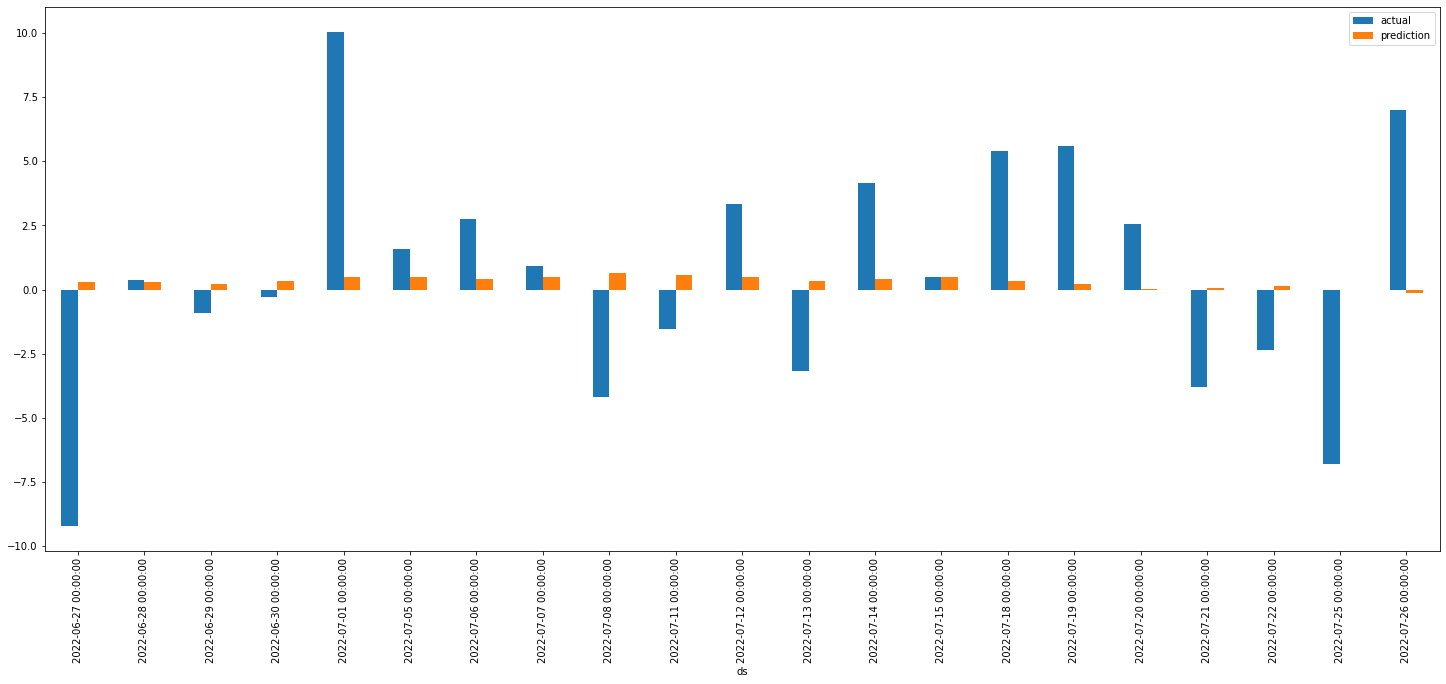

In [13]:
both.plot(y=['actual','prediction'],figsize=(25,10),kind='bar')

In [14]:
future = forecast[forecast.date >= (dt.datetime.now() - dt.timedelta(1))]
future

,date,prediction,pred_low,pred_high
23,2022-07-28,-0.218955,-3.672085,3.583335
24,2022-07-29,-0.114803,-3.596817,3.634788
25,2022-08-01,-0.180529,-3.787300,3.298880
26,2022-08-02,-0.240861,-3.955996,3.159839
27,2022-08-03,-0.353836,-4.099596,3.252660
28,2022-08-04,-0.238198,-3.968082,3.383513
29,2022-08-05,-0.086145,-3.664833,3.481950
